## Import Libraries

In [43]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Training model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

# Performance metrics calculation support library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt

## Data preprocessing

### Read data

In [44]:
df = pd.read_csv('../../../../Dataset/INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [45]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [46]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [47]:
#  Scaler data
scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [48]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.2)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size : len(df_scaled), :]

## Model training and testing

In [49]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [50]:
# Add data for train, validation and test set
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [51]:
# Make input for DFNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

### Training process

In [52]:
model = Sequential()

model.add(Dense(128, input_dim=time_step, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam') 

In [53]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/100


24/24 [==============================] - 1s 28ms/step - loss: 0.1619 - val_loss: 0.0029
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0037
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0034


### Validate Processing

In [54]:
train_predict=model.predict(X_train)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


### Testing Processing

In [55]:
y_pred=model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [56]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

### Evaluate Model

In [57]:
# Evaluate the accuracy of validation
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)

print(f"Validation MAPE: ", val_mape)
print(f"Validation RMSE: ", val_rmse)
print(f"Validation MSLE: ", val_msle)

Validation MAPE:  0.9940940219485193
Validation RMSE:  38.04771674415545
Validation MSLE:  11.764275836312398


In [58]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.9966920051678809
Testing RMSE:  31.368488019055455
Testing MSLE:  11.414138363107197


## Predicting the next 30 days

### Preparing the prediction data

In [59]:
x_input = val_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [60]:
# Print predict next 30 days
print(prediction_next30_days)

[[0.09407427161931992], [0.09048040956258774], [0.10548117756843567], [0.11035443097352982], [0.1148509606719017], [0.12598884105682373], [0.13073590397834778], [0.14980626106262207], [0.15200166404247284], [0.16885502636432648], [0.1696481704711914], [0.1727982461452484], [0.17885783314704895], [0.18354885280132294], [0.20331895351409912], [0.21607069671154022], [0.22875355184078217], [0.2372472882270813], [0.2389717698097229], [0.25503310561180115], [0.26013872027397156], [0.26648464798927307], [0.27498048543930054], [0.27451902627944946], [0.27607178688049316], [0.2844195067882538], [0.28681275248527527], [0.30412086844444275], [0.3081129491329193], [0.3269609808921814]]


### Preparing the forecast date index

In [61]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [62]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

## Visualization

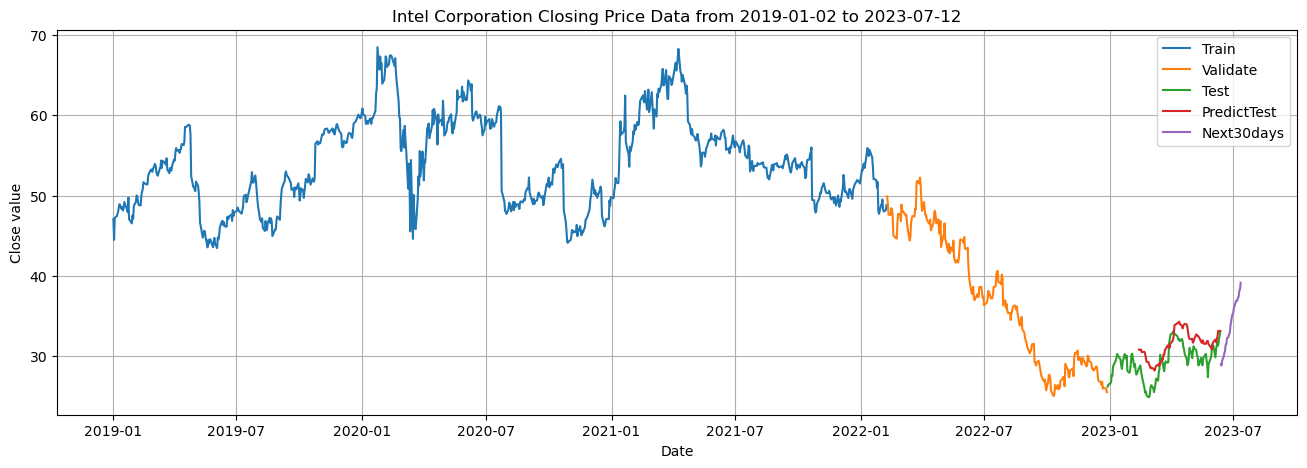

In [63]:
# Visualization
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + time_step: ], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.legend(['Train','Validate','Test','PredictTest','Next30days'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from 2019-01-02 to 2023-07-12")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('../Image/DFNN_622_INTC.png')
plt.show()